In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

In [30]:
df = pd.read_csv("../data/yna_news.csv")
df

,date,title,article,url,산업
0,2025-12-21,"""대리점 창업에 2억원 넘게 투자하지만…62%가 1년 단위 계약""","대리점 운영자들은 창업에 평균 2억원 넘게 투입하지만, 본사(공급업자)와의 계약은 ...",https://www.yna.co.kr/view/AKR2025122004540000...,자동차
1,2025-12-21,11월 車수출 13.7%↑…올해 연간 710억달러 넘겨 사상최고 전망,11월 한국의 자동차 수출이 작년 동월 대비 13.7% 증가하며 역대 11월 중 2...,https://www.yna.co.kr/view/AKR2025122102000000...,자동차
2,2025-12-21,"현대차, WFP에 아이오닉5·충전인프라 제공…구호영상도 공개",현대차는 유엔 소속의 식량 위기 대응 기구인 세계식량계획(WFP)에 아이오닉5 8대...,https://www.yna.co.kr/view/AKR2025122101710000...,자동차
3,2025-12-21,車업계 자국공장 폐쇄 잇따라…韓·中은 공격투자 '승부수',"글로벌 완성차 업체들이 전기차(EV) 수요 둔화와 중국발 저가 공세, 고금리·고비용...",https://www.yna.co.kr/view/AKR2025122004520000...,자동차
4,2025-12-21,연말 산타가 찾아온 업종은…자동차 웃고 헬스케어 울고,"올해 말 '산타'가 찾아온 업종은 무엇일까.\n이달 들어 자동차, 건설 등이 호조세...",https://www.yna.co.kr/view/AKR2025121915980000...,자동차
...,...,...,...,...,...
2847,2025-11-25,"신구, 이순재 별세에 ""같이 여행도 했었는데, 아쉽고 슬퍼""",원로 배우 이순재가 25일 천상의 무대로 떠나자 배우 신구(89)가 안타깝고 슬픈 ...,https://www.yna.co.kr/view/AKR2025112513660000...,해당없음
2848,2025-11-25,"춘천 애니메이션박물관, 공립박물관 평가인증 4회 연속 달성","\n이번 평가는 전시 운영, 교육 프로그램, 자료 수집·관리, 공적 책임, 설립 목...",https://www.yna.co.kr/view/AKR2025112513740006...,해당없음
2849,2025-11-25,"""연예계 큰 스승이 가셨다""…이순재 빈소에 조문 행렬","""'배우가 대사를 잃어버리면 안 된다'는 철학을 가지고 계셔서 기억력을 복구하시려고...",https://www.yna.co.kr/view/AKR2025112512910000...,해당없음
2850,2025-11-25,"넷플릭스 시리즈 '닭강정', 美 국제에미상서 고배",웹툰 원작 넷플릭스 시리즈 '닭강정'이 미국 방송 시상식인 국제에미상에서 고배를 마...,https://www.yna.co.kr/view/AKR2025112510320000...,해당없음


In [31]:
#article이 없는 행은 title로 채우기
df['article'] = df['article'].fillna(df['title'])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2852 entries, 0 to 2851
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     2852 non-null   object
 1   title    2852 non-null   object
 2   article  2852 non-null   object
 3   url      2852 non-null   object
 4   산업       2852 non-null   object
dtypes: object(5)
memory usage: 111.5+ KB


In [33]:
# article 컬럼이 결측치(Null)인 행들만 필터링
null_articles = df[df['article'].isnull()]

# 결과 출력 (날짜, 제목, 산업군 위주로 확인)
print(f"결측치 개수: {len(null_articles)}개")
display(null_articles[['date', 'title', '산업', 'url']])

결측치 개수: 0개


,date,title,산업,url


In [37]:
# 1. 하드웨어 체크
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 사용 중인 장치: {device}")

# 2. 데이터 준비
# df['본문']과 df['산업'] 컬럼 사용
le = LabelEncoder()
df['label'] = le.fit_transform(df['산업'])
num_labels = len(le.classes_)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['article'].tolist(), df['label'].tolist(), test_size=0.2, stratify=df['label'], random_state=42
)

# 3. 토크나이저 및 모델 로드 (KoBERT klue/roberta-base)
model_name = "klue/roberta-base" 
tokenizer = AutoTokenizer.from_pretrained(model_name)

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=256)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer)

# 4. 모델 설정
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

# 5. 학습 인자 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,              #  epochs 10회 
    per_device_train_batch_size=32,   
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",            # evaluation_strategy -> eval_strategy 로 변경
    fp16=True,                        
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10                  # 로그 확인
)

# 6. 트레이너 실행
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("학습 시작...")
trainer.train()

# 7. 모델 저장
model.save_pretrained("./my_kobert_model")
tokenizer.save_pretrained("./my_kobert_model")
np.save('classes.npy', le.classes_)
print("학습 및 저장 완료!")

현재 사용 중인 장치: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


학습 시작...


Epoch,Training Loss,Validation Loss
1,0.289100,0.296473
2,0.284600,0.238182
3,0.188500,0.292679
4,0.086500,0.308221
5,0.061100,0.312928
6,0.111100,0.350772
7,0.078900,0.320580
8,0.076600,0.317076
9,0.104600,0.352869
10,0.057500,0.344816


학습 및 저장 완료!


In [38]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm # 진행 상황 확인용

# 1. 환경 및 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "./my_kobert_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

# 레이블 복원
le_classes = np.load('classes.npy', allow_pickle=True)

# 2. 배치 추론 함수 (RTX 5080 최적화)
def classify_news_df(df, text_column='article', batch_size=64, threshold=0.8):
    model.eval()
    texts = df[text_column].fillna("").astype(str).tolist()
    predictions = []
    confidences = []

    print(f"총 {len(texts)}개의 기사를 분류합니다. (Batch Size: {batch_size})")
    
    with torch.inference_mode(): # no_grad보다 약간 더 빠름
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            
            # 토큰화 및 GPU 전송
            inputs = tokenizer(
                batch_texts, 
                return_tensors="pt", 
                truncation=True, 
                padding=True, 
                max_length=256
            ).to(device)
            
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            max_probs, idxs = torch.max(probs, dim=1)
            
            # 결과 저장
            for prob, idx in zip(max_probs.cpu().numpy(), idxs.cpu().numpy()):
                label = le_classes[idx]
                
                # 임계값 적용: 확신이 없으면 '미분류' 처리
                if prob < threshold:
                    predictions.append(f"미분류(낮은 확신도: {prob:.2f})")
                else:
                    predictions.append(label)
                confidences.append(float(prob))
                
    return predictions, confidences

# 3. 실행 및 결과 병합
# 데이터프레임 이름이 df라고 가정합니다.
df['AI_산업분류'], df['AI_확신도'] = classify_news_df(df)

# 4. 결과 시각화 및 확인
print("\n--- 분류 결과 샘플 ---")
print(df[['title', '산업', 'AI_산업분류', 'AI_확신도']].head(10))

# '해당없음'으로 태그된 기사들이 실제로 어떻게 분류되었는지 확인
print("\n--- '해당없음' 기사들에 대한 모델의 판단 ---")
print(df[df['산업'] == '해당없음'][['title', 'AI_산업분류', 'AI_확신도']].head(10))

# 5. 최종 저장
df.to_csv("news_classification_results.csv", index=False, encoding='utf-8-sig')

총 2852개의 기사를 분류합니다. (Batch Size: 64)


  0%|          | 0/45 [00:00<?, ?it/s]


--- 분류 결과 샘플 ---
                                         title   산업            AI_산업분류  AI_확신도
0         "대리점 창업에 2억원 넘게 투자하지만…62%가 1년 단위 계약"  자동차               해당없음  0.9844
1       11월 車수출 13.7%↑…올해 연간 710억달러 넘겨 사상최고 전망  자동차                자동차  0.9869
2            현대차, WFP에 아이오닉5·충전인프라 제공…구호영상도 공개  자동차                자동차  0.9888
3              車업계 자국공장 폐쇄 잇따라…韓·中은 공격투자 '승부수'  자동차                자동차  0.9885
4                연말 산타가 찾아온 업종은…자동차 웃고 헬스케어 울고  자동차                자동차  0.9835
5        K-중고차, 車수출 역성장 막았다…수출 84억달러로 작년의 1.8배  자동차                자동차  0.9866
6                   기아 하청노동자 '불법파견' 판단 항소심도 유지  자동차                자동차  0.9831
7                현대차 국내사업본부장 교체…신임 본부장에 윤효준 전무  자동차                자동차  0.9883
8                  오산 옹벽 붕괴 사고 조사 기간 2개월 추가 연장  자동차  미분류(낮은 확신도: 0.80)  0.7953
9  [K-VIBE] 정광복의 K-자율주행 도전기…도로 위 新 생태계를 주목하라-②  자동차                자동차  0.9876

--- '해당없음' 기사들에 대한 모델의 판단 ---
                                   title            AI_산업분류  AI_확신도
852           

### 분류 성능 리포트 ###
              precision    recall  f1-score   support

          건설       0.78      0.81      0.79       100
         자동차       0.95      0.98      0.96       486
        해당없음       0.98      0.97      0.98      1961
        헬스케어       0.95      0.95      0.95       228

    accuracy                           0.96      2775
   macro avg       0.92      0.93      0.92      2775
weighted avg       0.97      0.96      0.96      2775



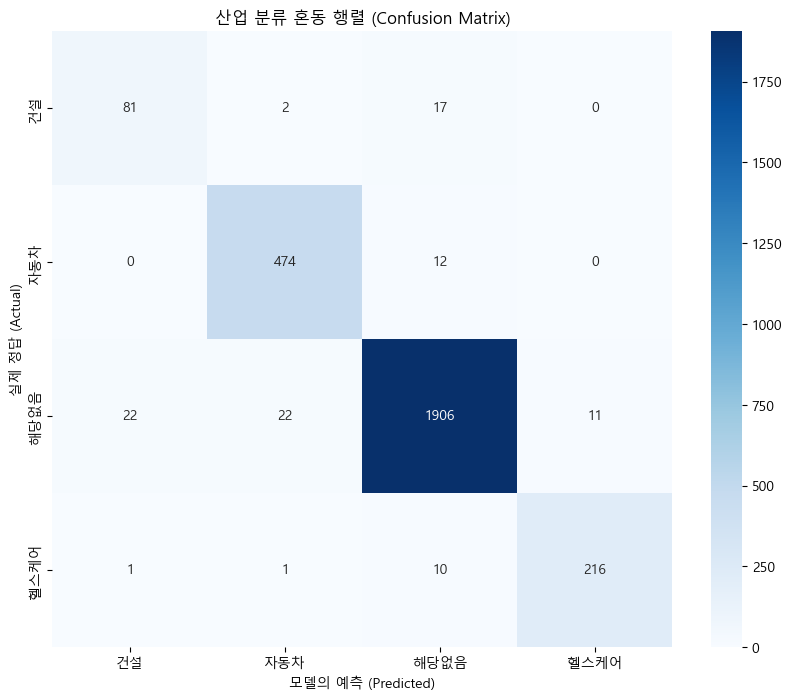

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 한글 폰트 설정 (차트에서 한글이 깨지지 않도록 설정)
plt.rcParams['font.family'] = 'Malgun Gothic' # 윈도우 기준
plt.rcParams['axes.unicode_minus'] = False

def plot_classification_results(df, true_col='산업', pred_col='AI_산업분류'):
    # '미분류'라고 나온 데이터는 평가를 위해 제외하거나 별도 처리해야 합니다.
    # 여기서는 모델이 예측한 값들만 추려서 비교합니다.
    eval_df = df[~df[pred_col].str.contains("미분류")].copy()
    
    true_labels = eval_df[true_col]
    pred_labels = eval_df[pred_col]
    
    # 1. 수치형 리포트 출력 (Precision, Recall, F1-score 포함)
    print("### 분류 성능 리포트 ###")
    print(classification_report(true_labels, pred_labels))
    
    # 2. Confusion Matrix (혼동 행렬) 생성
    cm = confusion_matrix(true_labels, pred_labels, labels=le_classes)
    
    # 3. 시각화 (Heatmap)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_classes, 
                yticklabels=le_classes)
    
    plt.title('산업 분류 혼동 행렬 (Confusion Matrix)')
    plt.xlabel('모델의 예측 (Predicted)')
    plt.ylabel('실제 정답 (Actual)')
    plt.show()

# 함수 실행
plot_classification_results(df)

In [ ]:
# 실제로는 건설이 아닌데, 모델이 건설이라고 예측한 기사들만 뽑기
wrong_construction = df[(df['산업'] != '건설') & (df['AI_산업분류'] == '건설')]
print(wrong_construction[['title', '산업', 'AI_확신도']].head(10))

In [9]:
# 1. KoELECTRA (효율성 및 문맥 파악 최적화)

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset

# 1. 하드웨어 체크 (RTX 5080 활용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"KoELECTRA 장치: {device}")

# 2. 데이터 준비 (기존 변수명 유지)
le = LabelEncoder()
df['label'] = le.fit_transform(df['산업'])
num_labels = len(le.classes_)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['article'].tolist(), df['label'].tolist(), test_size=0.2, stratify=df['label'], random_state=42
)

# 3. KoELECTRA 전용 토크나이저 및 모델 로드
model_name = "monologg/koelectra-base-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=256)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer)

# 4. 모델 설정
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

# 5. 학습 인자 설정 (RTX 5080 사양에 맞춰 배치 사이즈 상향 가능)
training_args = TrainingArguments(
    output_dir='./results_koelectra',
    num_train_epochs=10,
    per_device_train_batch_size=32,   # 5080이면 64까지 늘려도 넉넉합니다
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs_koelectra',
    eval_strategy="epoch",
    fp16=True,                      # 5080 성능 최적화
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10
)

# 6. 트레이너 실행
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("KoELECTRA 학습 시작...")
trainer.train()

# 7. 모델 저장
model.save_pretrained("./my_koelectra_model")
tokenizer.save_pretrained("./my_koelectra_model")
np.save('classes_koelectra.npy', le.classes_)
print("KoELECTRA 학습 및 저장 완료!")

KoELECTRA 장치: cuda


pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

C:\Users\kimjh\anaconda3\envs\ml-dl-nlp\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kimjh\.cache\huggingface\hub\models--monologg--koelectra-base-v3-discriminator. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of ElectraForSequenceClassification were not initialized from the model che

KoELECTRA 학습 시작...


Epoch,Training Loss,Validation Loss
1,0.713000,0.605773
2,0.433600,0.385358
3,0.240900,0.261414
4,0.145400,0.261152
5,0.139000,0.284558
6,0.111400,0.244396
7,0.103500,0.247738
8,0.101400,0.249626
9,0.113400,0.263251
10,0.075000,0.266799


model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

KoELECTRA 학습 및 저장 완료!


In [15]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# 1. 하드웨어 체크
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 데이터 정제 (NaN 제거)
df['article'] = df['article'].fillna("").astype(str)

# 3. KcELECTRA 전용 설정
model_name_kc = "beomi/KcELECTRA-base" # 모델 경로 확인
tokenizer_kc = AutoTokenizer.from_pretrained(model_name_kc)
model_kc = AutoModelForSequenceClassification.from_pretrained(model_name_kc, num_labels=num_labels).to(device)

# 4. 데이터셋 생성
train_dataset_kc = NewsDataset(train_texts, train_labels, tokenizer_kc)
val_dataset_kc = NewsDataset(val_texts, val_labels, tokenizer_kc)

# 5. 학습 인자 설정 (5080 최적화)
training_args_kc = TrainingArguments(
    output_dir='./results_kcelectra',
    num_train_epochs=10,
    per_device_train_batch_size=64, # RTX 5080 VRAM 활용
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    fp16=True,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10
)

# 6. 학습 시작
trainer_kc = Trainer(
    model=model_kc,
    args=training_args_kc,
    train_dataset=train_dataset_kc,
    eval_dataset=val_dataset_kc,
)

print("KcELECTRA 학습을 시작합니다...")
trainer_kc.train()

# 7. 모델 저장 (이 이름으로 폴더가 생성됩니다)
model_kc.save_pretrained("./my_kcelectra_model")
tokenizer_kc.save_pretrained("./my_kcelectra_model")
np.save('classes_kcelectra.npy', le.classes_)
print("KcELECTRA 학습 및 폴더 저장 완료!")

tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

C:\Users\kimjh\anaconda3\envs\ml-dl-nlp\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kimjh\.cache\huggingface\hub\models--beomi--KcELECTRA-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/514 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KcELECTRA 학습을 시작합니다...


Epoch,Training Loss,Validation Loss
1,0.751700,0.653848
2,0.476400,0.467605
3,0.325600,0.399733
4,0.207700,0.333165
5,0.160600,0.319255
6,0.117600,0.350373
7,0.131700,0.312169
8,0.103700,0.355519
9,0.085400,0.356022
10,0.089200,0.344741


KcELECTRA 학습 및 폴더 저장 완료!


In [42]:
import torch
import numpy as np
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report

# 1. 모델 저장 폴더명 정의
model_folders = {
    "KLUE-RoBERTa": "my_kobert_model",
    "KoELECTRA": "my_koelectra_model",
    "KcELECTRA": "my_kcelectra_model"
}

all_results = []

print("모델별 성능 테스트를 시작합니다 (절대 경로 적용)...")

for name, folder in model_folders.items():
    # os.path.abspath를 사용하여 ./ 경로 문제를 해결합니다.
    full_path = os.path.abspath(folder)
    print(f"\n[{name}] 테스트 중... (경로: {full_path})")
    
    try:
        # 모델 및 토크나이저 로드
        tokenizer = AutoTokenizer.from_pretrained(full_path)
        model = AutoModelForSequenceClassification.from_pretrained(full_path).to(device)
        
        # 테스트 데이터셋 생성 (기존 NewsDataset 활용)
        test_dataset = NewsDataset(val_texts, val_labels, tokenizer)
        
        # 평가 실행 (RTX 5080의 속도를 활용)
        test_args = TrainingArguments(
            output_dir='./temp_eval', 
            per_device_eval_batch_size=64, 
            report_to="none"
        )
        tester = Trainer(model=model, args=test_args)
        
        raw_preds = tester.predict(test_dataset)
        y_pred = np.argmax(raw_preds.predictions, axis=1)
        
        # 지표 계산
        report = classification_report(val_labels, y_pred, target_names=le.classes_, output_dict=True)
        
        all_results.append({
            "Model": name,
            "Accuracy": report['accuracy'],
            "Macro F1": report['macro avg']['f1-score'],
            "건설 F1": report['건설']['f1-score'],
            "건설 Recall": report['건설']['recall'],
            "자동차 F1": report['자동차']['f1-score']
        })
        print(f"{name} 평가 완료!")

    except Exception as e:
        print(f"{name} 평가 실패 사유: {e}")

# 최종 결과 비교 테이블
if all_results:
    df_final = pd.DataFrame(all_results)
    print("\n" + "="*70)
    print("3종 모델 최종 성능 비교 결과")
    print("="*70)
    print(df_final.to_string(index=False))

모델별 성능 테스트를 시작합니다 (절대 경로 적용)...

[KLUE-RoBERTa] 테스트 중... (경로: E:\ai\lecNote\10_1stProject\yna_news\my_kobert_model)


KLUE-RoBERTa 평가 완료!

[KoELECTRA] 테스트 중... (경로: E:\ai\lecNote\10_1stProject\yna_news\my_koelectra_model)


KoELECTRA 평가 완료!

[KcELECTRA] 테스트 중... (경로: E:\ai\lecNote\10_1stProject\yna_news\my_kcelectra_model)


KcELECTRA 평가 완료!

3종 모델 최종 성능 비교 결과
       Model  Accuracy  Macro F1  건설 F1  건설 Recall  자동차 F1
KLUE-RoBERTa    0.9352    0.8640 0.6154     0.6154  0.9300
   KoELECTRA    0.9335    0.8570 0.6122     0.5769  0.9400
   KcELECTRA    0.9124    0.8363 0.6071     0.6538  0.9010


### 산업별 상세 지표 (KLUE-RoBERTa) ###
      precision  recall  f1-score  support
건설       0.5667  0.6538    0.6071  26.0000
자동차      0.8750  0.9286    0.9010  98.0000
헬스케어     0.9302  0.8696    0.8989  46.0000
해당없음     0.9467  0.9302    0.9384 401.0000


<Figure size 1000x500 with 0 Axes>

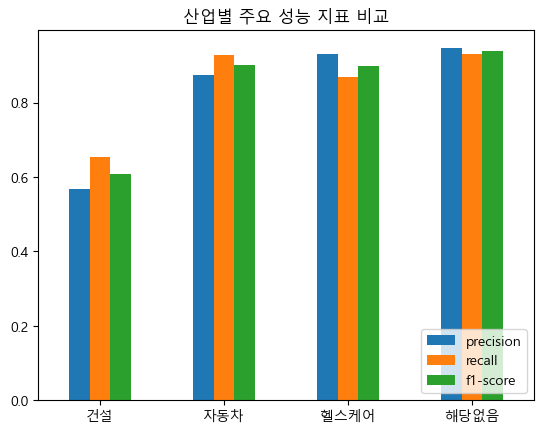

In [41]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 상세 리포트 생성
# y_true는 val_labels, y_pred는 모델의 예측값입니다.
report_dict = classification_report(val_labels, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# 2. '건설', '자동차', '헬스케어', '해당없음'만 필터링해서 출력
target_industries = ['건설', '자동차', '헬스케어', '해당없음']
print("### 산업별 상세 지표 (KLUE-RoBERTa) ###")
print(report_df.loc[target_industries, ['precision', 'recall', 'f1-score', 'support']])

# 3. 시각화 (각 지표별 비교)
plt.figure(figsize=(10, 5))
plt.rcParams['font.family'] = 'Malgun Gothic'
report_df.loc[target_industries, ['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title('산업별 주요 성능 지표 비교')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

In [43]:
import torch
import numpy as np
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report

# 1. 하드웨어 및 데이터 준비 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 저장 폴더명 (실제 생성된 폴더명과 일치해야 합니다)
model_folders = {
    "KLUE-RoBERTa": "my_kobert_model",
    "KoELECTRA": "my_koelectra_model",
    "KcELECTRA": "my_kcelectra_model"
}

def get_model_metrics(model_name, folder_path, texts, labels, target_names):
    full_path = os.path.abspath(folder_path)
    print(f"[{model_name}] 평가 중...")
    
    # 모델/토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(full_path)
    model = AutoModelForSequenceClassification.from_pretrained(full_path).to(device)
    
    # 데이터셋 및 트레이너 설정
    test_dataset = NewsDataset(texts, labels, tokenizer)
    test_args = TrainingArguments(output_dir='./temp', per_device_eval_batch_size=64, report_to="none")
    tester = Trainer(model=model, args=test_args)
    
    # 예측 및 지표 계산
    output = tester.predict(test_dataset)
    y_pred = np.argmax(output.predictions, axis=1)
    report = classification_report(labels, y_pred, target_names=target_names, output_dict=True)
    
    # 원하는 모든 지표 추출
    res = {
        "Model": model_name,
        "Accuracy": report['accuracy'],
        "Macro F1": report['macro avg']['f1-score'],
        # 건설
        "건설_F1": report['건설']['f1-score'],
        "건설_Recall": report['건설']['recall'],
        "건설_Precision": report['건설']['precision'],
        # 자동차
        "자동차_F1": report['자동차']['f1-score'],
        "자동차_Recall": report['자동차']['recall'],
        "자동차_Precision": report['자동차']['precision'],
        # 헬스케어
        "헬스케어_F1": report['헬스케어']['f1-score'],
        "헬스케어_Recall": report['헬스케어']['recall'],
        "헬스케어_Precision": report['헬스케어']['precision']
    }
    return res

# 2. 실행 및 결과 수합
final_results = []
for name, folder in model_folders.items():
    if os.path.exists(folder):
        try:
            metrics = get_model_metrics(name, folder, val_texts, val_labels, le.classes_)
            final_results.append(metrics)
        except Exception as e:
            print(f"{name} 평가 중 오류 발생: {e}")
    else:
        print(f"경고: {folder} 폴더가 존재하지 않습니다.")

# 3. 데이터프레임 변환 및 출력
if final_results:
    df_final = pd.DataFrame(final_results)
    
    # 컬럼 순서 조정 (보기 좋게)
    cols = ["Model", "Accuracy", "Macro F1", 
            "건설_F1", "건설_Recall", "건설_Precision",
            "자동차_F1", "자동차_Recall", "자동차_Precision",
            "헬스케어_F1", "헬스케어_Recall", "헬스케어_Precision"]
    
    df_final = df_final[cols]
    pd.options.display.float_format = '{:.4f}'.format
    
    print("\n" + "="*120)
    print("3종 모델 산업별 상세 성능 비교표")
    print("="*120)
    print(df_final.to_string(index=False))
else:
    print("평가 결과가 없습니다. 모델 폴더를 확인해주세요.")

[KLUE-RoBERTa] 평가 중...


[KoELECTRA] 평가 중...


[KcELECTRA] 평가 중...



3종 모델 산업별 상세 성능 비교표
       Model  Accuracy  Macro F1  건설_F1  건설_Recall  건설_Precision  자동차_F1  자동차_Recall  자동차_Precision  헬스케어_F1  헬스케어_Recall  헬스케어_Precision
KLUE-RoBERTa    0.9335    0.8574 0.6122     0.5769        0.6522  0.9300      0.9490         0.9118   0.9333       0.9130          0.9545
   KoELECTRA    0.9335    0.8570 0.6122     0.5769        0.6522  0.9400      0.9592         0.9216   0.9231       0.9130          0.9333
   KcELECTRA    0.9124    0.8363 0.6071     0.6538        0.5667  0.9010      0.9286         0.8750   0.8989       0.8696          0.9302


In [50]:
import torch
import numpy as np
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, accuracy_score

# 1. 하드웨어 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 저장 폴더명 확인
model_folders = {
    "KLUE-RoBERTa": "my_kobert_model",
    "KoELECTRA": "my_koelectra_model",
    "KcELECTRA": "my_kcelectra_model"
}

def get_model_metrics(model_name, folder_path, texts, labels, target_names):
    full_path = os.path.abspath(folder_path)
    print(f"[{model_name}] 평가 중...")
    
    tokenizer = AutoTokenizer.from_pretrained(full_path)
    model = AutoModelForSequenceClassification.from_pretrained(full_path).to(device)
    
    test_dataset = NewsDataset(texts, labels, tokenizer)
    test_args = TrainingArguments(output_dir='./temp', per_device_eval_batch_size=64, report_to="none")
    tester = Trainer(model=model, args=test_args)
    
    # 예측 수행
    output = tester.predict(test_dataset)
    y_pred = np.argmax(output.predictions, axis=1)
    y_true = np.array(labels)
    
    # 전체 리포트 생성
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    
    # --- 산업별 개별 Accuracy(Binary) 계산 ---
    def get_bin_acc(idx):
        return accuracy_score((y_true == idx), (y_pred == idx))

    # 결과 수합
    res = {
        "Model": model_name,
        "Total_Acc": report['accuracy'],
        "Macro_F1": report['macro avg']['f1-score'],
        
        # 건설 (Index 0 가정, le.classes_ 순서에 따름)
        "건설_F1": report['건설']['f1-score'],
        "건설_Recall": report['건설']['recall'],
        "건설_Acc": get_bin_acc(list(target_names).index('건설')),
        
        # 자동차
        "자동차_F1": report['자동차']['f1-score'],
        "자동차_Recall": report['자동차']['recall'],
        "자동차_Acc": get_bin_acc(list(target_names).index('자동차')),
        
        # 헬스케어
        "헬스케어_F1": report['헬스케어']['f1-score'],
        "헬스케어_Recall": report['헬스케어']['recall'],
        "헬스케어_Acc": get_bin_acc(list(target_names).index('헬스케어')),

        # 해당없음
        "해당없음_Acc": get_bin_acc(list(target_names).index('해당없음'))
    }
    return res

# 2. 실행 및 결과 수합
final_results = []
for name, folder in model_folders.items():
    if os.path.exists(folder):
        try:
            # val_texts, val_labels, le.classes_가 사전에 정의되어 있어야 합니다.
            metrics = get_model_metrics(name, folder, val_texts, val_labels, le.classes_)
            final_results.append(metrics)
        except Exception as e:
            print(f"{name} 평가 중 오류 발생: {e}")

# 3. 데이터프레임 출력
if final_results:
    df_final = pd.DataFrame(final_results)
    pd.options.display.float_format = '{:.4f}'.format
    
    print("\n" + "="*140)
    print("3종 모델 산업별 상세 성능 및 Accuracy 비교표")
    print("="*140)
    print(df_final.to_string(index=False))
else:
    print("평가 결과가 없습니다.")

[KLUE-RoBERTa] 평가 중...


[KoELECTRA] 평가 중...


[KcELECTRA] 평가 중...



3종 모델 산업별 상세 성능 및 Accuracy 비교표
       Model  Total_Acc  Macro_F1  건설_F1  건설_Recall  건설_Acc  자동차_F1  자동차_Recall  자동차_Acc  헬스케어_F1  헬스케어_Recall  헬스케어_Acc  해당없음_Acc
KLUE-RoBERTa     0.9335    0.8574 0.6122     0.5769  0.9667  0.9300      0.9490   0.9755   0.9333       0.9130    0.9895    0.9352
   KoELECTRA     0.9335    0.8570 0.6122     0.5769  0.9667  0.9400      0.9592   0.9790   0.9231       0.9130    0.9877    0.9335
   KcELECTRA     0.9124    0.8363 0.6071     0.6538  0.9615  0.9010      0.9286   0.9650   0.8989       0.8696    0.9842    0.9142
